In [11]:
# imports
import numpy as np
import pandas as pd
from simanneal import Annealer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.plots import plot_convergence
import random
from warnings import catch_warnings, simplefilter, filterwarnings

# *Self Assessment: Simulated Annealing for Value Balancing*

In [36]:
import numpy as np
import pandas as pd

# the objective function
def group_fitness(groups, values, num_groups):
    sums = np.array([ sum( values[ groups == i] ) for i in range(num_groups) ])
    return max(sums)-min(sums)

# the move function
def change_group(groups, num_groups, debug=False):
    #get the unique groups
    choices = np.arange(0,num_groups)
    #get a copy of the groups
    new_groups = groups.copy()    
    #select item to change
    switch = np.random.randint(0, groups.shape[0])
    #select new group value
    new_group = np.random.choice(choices)
    while groups[switch] == new_group:
        new_group = np.random.choice(choices)
    new_groups[switch] = new_group    
    if debug:
        print(f'The item at {switch} should change to {new_group}')
        print(f'The initial groups are: {groups} and the changed groups are {new_groups}')
    return new_groups

# simulated annealing
def group_balance_anneal(values, num_groups, max_no_improve, init_temp, alpha, debug=False):
    
    num_items = values.shape[0]
    current_groups = np.random.randint(low=0,high=num_groups, size=num_items)
    current_fitness =  group_fitness(current_groups, values, num_groups)

    best_fitness = current_fitness
    best_groups = current_groups
        
    num_moves_no_improve = 0
    iterations = 0
    acceptances = 0
    temp = init_temp
    
    history = np.array([[iterations, current_fitness, best_fitness]])
    
    while (num_moves_no_improve < max_no_improve):
        iterations += 1
        num_moves_no_improve += 1
        new_groups = change_group(current_groups, num_groups, debug)
        new_fitness = group_fitness(new_groups, values, num_groups)
        delta = current_fitness - new_fitness
        prob = np.exp(min(delta,0) / temp)
        if debug:
            print(f'Old fitness: {current_fitness}, New fitness {new_fitness}')
        if new_fitness < current_fitness or np.random.uniform() < prob:
            acceptances += 1
            current_fitness = new_fitness
            current_groups = new_groups
            if current_fitness < best_fitness:
                best_groups = current_groups
                best_fitness = current_fitness
                num_moves_no_improve = 0
            
        temp *= alpha
        
        history = np.vstack( (history, np.array([[iterations,current_fitness,best_fitness]]) ) )
        
    print(f'acceptance rate: {acceptances/iterations:0.2f}')
        
    return best_fitness, best_groups, iterations, history

acceptance rate: 1.00
The minimized maximum difference between groups is 0


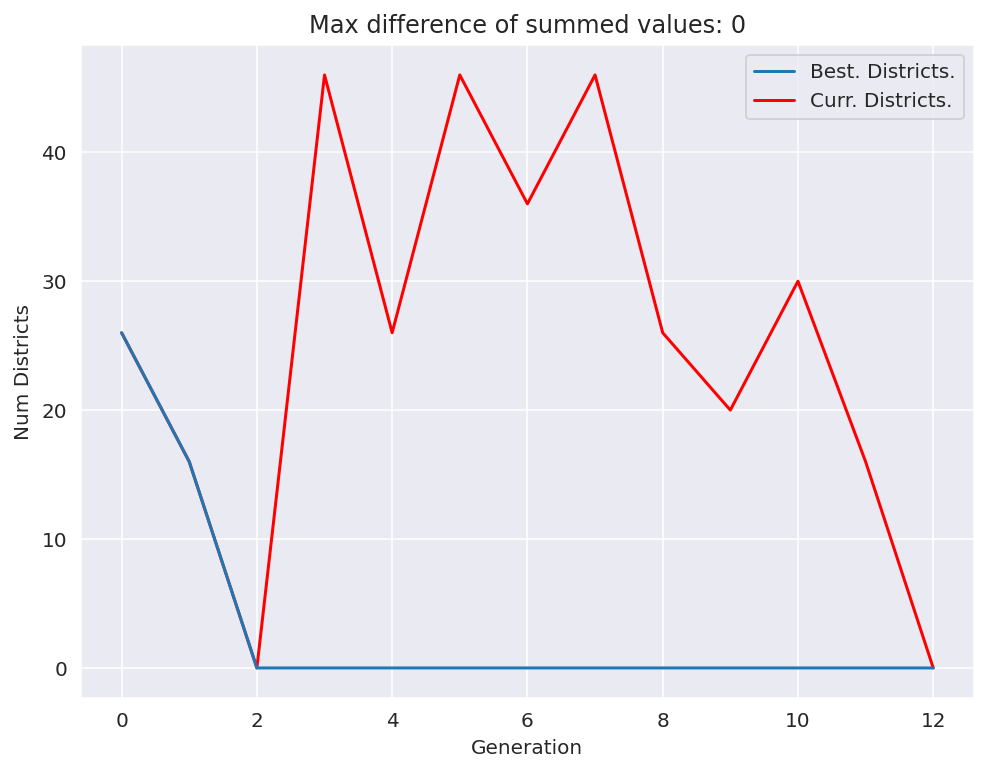

In [37]:
# run and plot for small test problem

values = np.array([5,10,23,8])
groups = np.array([0,1,0,1])

num_groups = 2
max_no_improve = 10
init_temp = 100
alpha = 0.99
best_fitness, best_groups, iterations, history = group_balance_anneal(values, num_groups, max_no_improve, init_temp, alpha)

print(f"The minimized maximum difference between groups is {best_fitness:.0f}")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], history[:,1], label='Curr. Districts.',color='red')
line_curr, = plt.plot(history[:,0],history[:,2], label='Best. Districts.')
plt.xlabel('Generation')
plt.ylabel('Num Districts')
plt.legend(handles=[line_curr, line_min])
plt.title('Max difference of summed values: {:d}'.format(int(best_fitness)));

acceptance rate: 0.29
The minimized maximum difference between groups is 7
The objective function was evaluated 16438 times


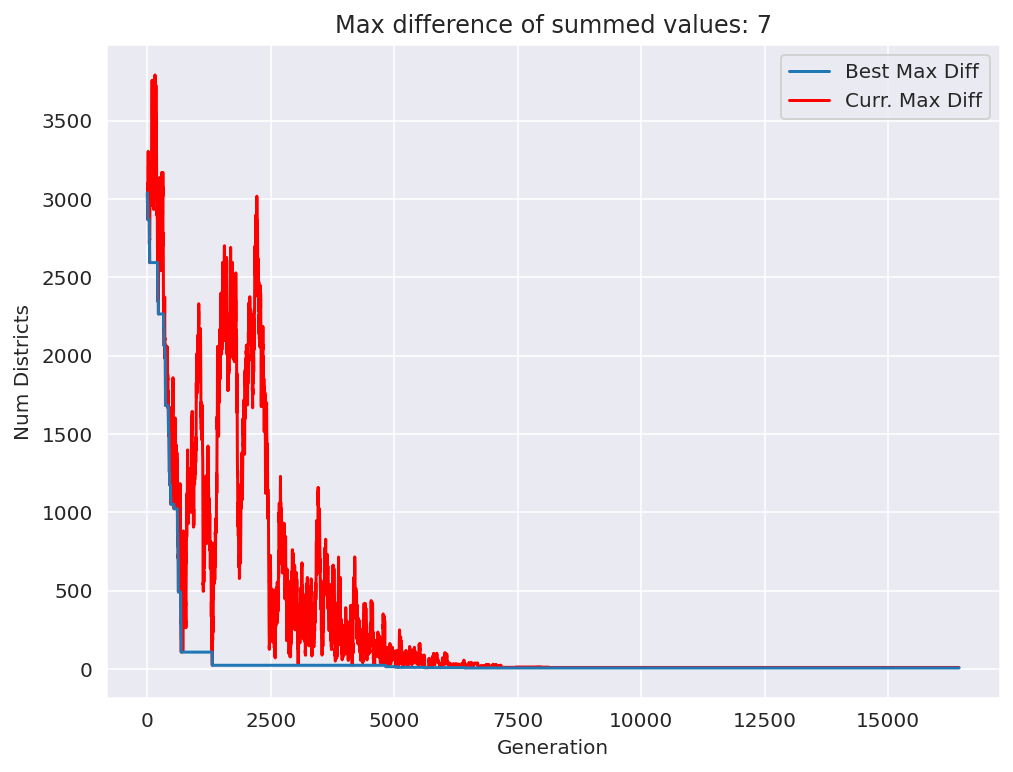

In [38]:
# run and plot for 1000 item / 4 group problem

# the weird construction here guarantees that 4 groups can be perfectly balanced so the global min is zero

np.random.seed(123)

tot_num_items = 1000 # should be divisible by 4
num_items = int(tot_num_items / 4)
num_groups = 4

values = np.random.randint(10,100,size=num_items)
values = np.hstack([values,values,values,values])
groups = np.random.randint(num_groups,size=tot_num_items)

np.random.seed()

max_no_improve = 10000
init_temp = 5000
alpha = 0.999
best_fitness, best_groups, iterations, history = group_balance_anneal(values, num_groups, max_no_improve, init_temp, alpha)

print(f"The minimized maximum difference between groups is {best_fitness:.0f}")

print(f'The objective function was evaluated {iterations:.0f} times')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], history[:,1], label='Curr. Max Diff',color='red')
line_curr, = plt.plot(history[:,0],history[:,2], label='Best Max Diff')
plt.xlabel('Generation')
plt.ylabel('Num Districts')
plt.legend(handles=[line_curr, line_min])
plt.title('Max difference of summed values: {:d}'.format(int(best_fitness)));

# *Self Assessment: Use simanneal package for Value Balancing*

This time we'll solve just the large problem.  In the first cell below we include all of the helper functions and data generation:

In [39]:
import numpy as np
import pandas as pd

# the objective function
def group_fitness(groups,values,num_groups):
    # groups must be a numpy array for this to work
    sums = np.array([ sum( values[ groups == i] ) for i in range(num_groups) ])
    return max(sums)-min(sums)

# the move function
def change_group(groups, num_groups, debug=False):
    #get the unique groups
    choices = np.arange(0,num_groups)
    #get a copy of the groups
    new_groups = groups.copy()    
    #select item to change
    switch = np.random.randint(0, groups.shape[0])
    #select new group value
    new_group = np.random.choice(choices)
    while groups[switch] == new_group:
        new_group = np.random.choice(choices)
    new_groups[switch] = new_group    
    if debug:
        print(f'The item at {switch} should change to {new_group}')
        print(f'The initial groups are: {groups} and the changed groups are {new_groups}')
    return new_groups

# the weird construction here guarantees that 4 groups can be perfectly balanced so the global min is zero

np.random.seed(123)

tot_num_items = 1000 # should be divisible by 4
num_items = int(tot_num_items / 4)
num_groups = 4

values = np.random.randint(10,100,size=num_items)
values = np.hstack([values,values,values,values])
groups = np.random.randint(num_groups,size=1000)

np.random.seed()

In [40]:
# must execute the cell labeled "load problem data and define objective and move functions"
# in the previous self-assessment

from simanneal import Annealer

class ValueBalancingProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, values, num_groups, debug = False):
        # state is the groups assignment
        self.values = values
        self.num_groups = num_groups
        self.debug = debug
        super(ValueBalancingProblem, self).__init__(state)  # important!

    def move(self):
        """Move one item to a new group"""
        self.state = change_group( self.state, self.num_groups, debug = self.debug)
    
    def energy(self):
        """Compute max difference between groups"""
        return group_fitness(self.state, self.values, self.num_groups)

initial_groups = groups # defined in previous cell
vbp = ValueBalancingProblem(initial_groups, values, num_groups, debug = False)

# auto scheduling times are VERY approximate
vbp.set_schedule(vbp.auto(minutes=.2)) #set approximate time to find results

# uncomment the following 3 lines to manually control the temperatu

best_groups, best_fitness = vbp.anneal()

print(f'best fitness {best_fitness}')
print(f'The objective function was evaluated {vbp.steps:.0f} times.')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


best fitness 4
The objective function was evaluated 74000 times.


In [0]:
class KnapsackProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, weights, values, max_weight, num_items):
        # state is the groups assignment
        self.values = values
        self.weights = ...
        super(KnapsackProblem, self).__init__(state)  # important!

    def move(self):
        """Move one item to a new group"""
        x = self.state
        num_items = self.num_items
        new_x = x.copy()  #randomly flip one bit
        bit_to_flip = np.random.randint(num_items)
        new_x[bit_to_flip] = not new_x[bit_to_flip]
        compute the total weight of items in new_x
        if total_weight <= self.max_weight:
            self.state = new_x
        
    
    def energy(self):
        """Compute max difference between groups"""
        return negated tot_value of items in self.state
        #return group_fitness(self.state, self.values, self.num_groups)

initial_groups = groups # defined in previous cell
vbp = ValueBalancingProblem(initial_groups, values, num_groups, debug = False)

# auto scheduling times are VERY approximate
vbp.set_schedule(vbp.auto(minutes=.2)) #set approximate time to find results

# uncomment the following 3 lines to manually control the temperatu

best_groups, best_fitness = vbp.anneal()

print(f'best fitness {best_fitness}')
print(f'The objective function was evaluated {vbp.steps:.0f} times.')

# *Self-Assessment for Simulated Annealing with Continuous Variables*

In [7]:
# Self-Assessment Solution for Simulated Annealing with Continuous Variables

def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

def gauss_move(xy,sigma):
    # xy is a 1 by dim numpy array
    # sigma is the standard deviation for the normal distribution
    dim = len(xy)
    return xy + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(xy,low,high):
    # xy is a 1 by dim numpy array
    # low is the lower bound for clipping variables
    # high is the upper bound for clipping variables
    return np.array( [min(high,max(low,v)) for v in xy])

class NonConvex2D(Annealer):

    # no extra data so just initialize with state
    def __init__(self, state, sigma, low, high):
        self.sigma = sigma
        self.low = low
        self.high = high
        super(NonConvex2D, self).__init__(state)  # important!

    def move(self):
        self.state = gauss_move(self.state, self.sigma)
        self.state = clip_to_bounds(self.state, self.low, self.high)

    def energy(self):
        return f(self.state)

init_state = np.random.uniform(low=-1,high=1,size=2)
sigma = 1/3
low = -1
high = 1

problem2D = NonConvex2D( init_state, sigma, low, high )
#problem2D.set_schedule(problem2D.auto(minutes=.2))
problem2D.Tmax = 10000.0  # Max (starting) temperature
problem2D.Tmin = 0.1     # Min (ending) temperature
problem2D.steps = 5000   # Number of iterations
best_x, best_fun = problem2D.anneal()

print("Notice that the results below are displayed using scientific notation.\n")
print(f"The lowest function value found by simulated annealing is {best_fun:.3e}")
print(f"That value is achieved when x = {best_x[0]:.3e} and y = {best_x[1]:.3e}")
# refine with local search
from scipy.optimize import minimize

result = minimize(f,best_x)
print("\nAfter refining the result from simulated annealing with local search.")
print(f"The lowest function value found by local search is {result.fun:.3e}")
print(f"That value is achieved when x = {result.x[0]:.3e} and y = {result.x[1]:.3e}")

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Notice that the results below are displayed using scientific notation.

The lowest function value found by simulated annealing is 4.774e-06
That value is achieved when x = 4.410e-04 and y = -2.448e-04

After refining the result from simulated annealing with local search.
The lowest function value found by local search is 8.404e-14
That value is achieved when x = -3.500e-08 and y = -5.704e-08


Notice that we get close to the optimal solution, but only to within 5 or so decimal places.  Simulated annealing is very good at exploring the entire space of solutions but is not so efficient at converging to a nearby minimum value.  Most practical simulated annealing type search algorithms for continuous optimization combine a gradient based local search with the annealing process to promote faster convergence.

# Self-Assessment - Bayesian Optimization of the Booth function

Use Bayesian Optimization (`gp_minimize`) to estimate the global minimum value of the Booth function, a common optimization test problem:

$f(x,y)=(x+2y-7)^2+(2x+y-5)^2$

for $x$ and $y$ both in [-10,10].

The minimum value of f(x) is 0.0000 and occurs at x=1.0000, y=3.0000


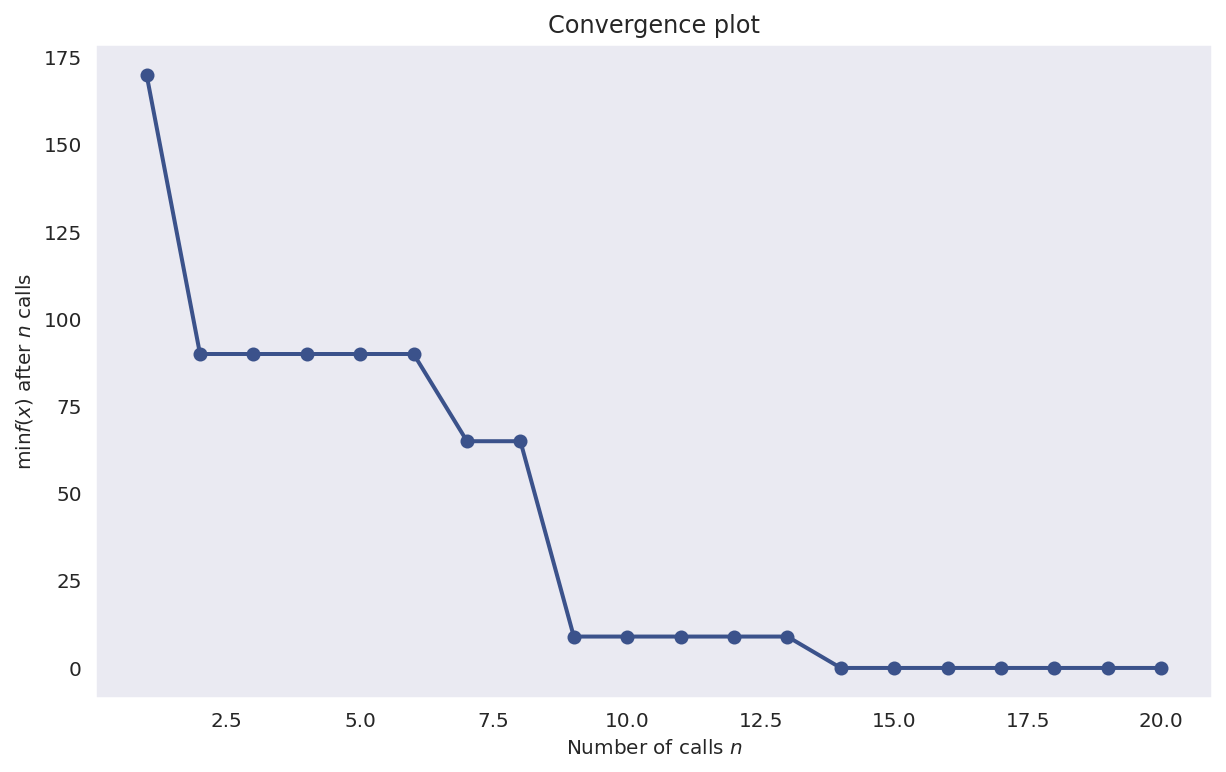

In [13]:
filterwarnings('ignore') # suppress some of the warnings from B.O.

np.random.seed(42)

# same "bumpy" function as in simulated annealing, just written differently
# assumes xy is a list or array-like with xy = [x, y]
def booth(xy):
    x = xy[0]
    y = xy[1]
    obj = (x+2*y-7)**2 + (2*x+y-5)**2
    return obj

#call the optimization.
res = gp_minimize(booth,                  # the function to minimize
                  [(-10, 10)]*2,      # the bounds on each dimension of x
                 acq_func="EI",      # the acquisition function 
                  n_calls=20,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)   # the random seed

print(f'The minimum value of f(x) is {res.fun:0.4f} and occurs at x={res.x[0]:0.4f}, y={res.x[1]:0.4f}')

fig = plt.figure(figsize=(10,6)) # we initialize the plot so we can control dimensions
ax = fig.add_axes
plot_convergence(res,ax);